# Identity
Name: Michelle Nathania\
Student ID: 2702208575\
Code A

# 1. ANN for energy usage prediction

Before we begin, let's import all the libraries needed for this project. I will mainly use Tensorflow libraries for building the neural models.

In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import random as rd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras_tuner as kt
from keras import backend as K

import gc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Set seed for a more reproducible result
# So every time it runs the result won't differ much
SEED_VALUE=123
rd.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

## a. EDA and Data preprocessing

In [ ]:
# Read the parquet dataset using pandas
df = pd.read_parquet("dataset_1A.parquet")

In [ ]:
# Check the head & tail, ensuring the dataset has been imported successfully
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


In [ ]:
df.tail()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
1227,9,2,Saturday,No,29.412360,47.368427,1905.249762,3,On,Off,9.602456,79.74911905310127
1228,6,16,Saturday,Yes,24.019593,59.272447,1274.096723,9,Off,On,21.973733,72.93770990438871
1229,1,1,Tuesday,No,21.926454,44.605974,1135.054165,5,On,On,4.858261,77.02412225998496
1230,3,2,Monday,No,24.581719,32.637069,1295.556323,5,Off,Off,1.763935,71.75136050151936
1231,12,17,Sunday,Yes,22.229281,46.942542,1330.187266,6,On,On,20.657222,72.10855378660037


The dataset has been imported successfully, proven by the successful head and tail checking. This dataset has an objective as follows:

Goal: Predict the amount of energy consumed by a building with solar panel!

- **Month**: The month of the year when the data was recorded.
- **Hour**: The hour of the day when the data was recorded.
- **DayOfWeek**: The day of the week when the data was recorded.
- **Holiday**: Indicates whether the day was a holiday (Yes/No).
- **Temperature**: The average daily temperature in Celsius
- **Humidity**: The average daily humidity level (%).
- **SquareFootage**: The area of the building being monitored in square meters.
- **Occupancy**: The total number of people occupying the building.
- **HVACUsage**: Indicates whether the HVAC system was in use (On/Off).
- **LightingUsage**: Indicates whether the lighting system was in use (On/Off).
- **RenewableEnergy**: The amount of renewable energy generated at the time of data collection.
- **EnergyConsumption**: The amount of energy consumed at the time of data collection.

### Check the number of rows and columns
Understanding the number of rows and columns is necessary because we can understand how many data points do we have (if we have sufficient amount of them or not) and understanding the dimensionality of our dataset.

In [ ]:
'''
The df.shape syntax will return 2 arguments,
the first index showing the number of rows, and the second showing the number of columns.
Example: [10, 24] means the data has 10 rows and 24 columns.
For better readability, I will call the df.shape[0] for rows and df.shape[1] for columns.
'''
print(f"# of rows: ", df.shape[0])
print(f"# of columns: ", df.shape[1])

# of rows:  1232
# of columns:  12


The dataset has 1232 rows and 12 columns.

### Check the data information
By using df.info(), we are able to obtain information such as the column names, non-null count for each column, and the datatype. It's like killing two birds with one stone -- understanding multiple information of the dataset at once.

In [ ]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


From the imported data, we can understand that there are some numerical (int and float) and categorical (object) variables present. To distinguish them easily, let's **divide them into num** (for numerical var) and **cat** (for categorical var) so we can do **EDA and preprocessing according to the datatype**.

From the datatype, I noticed this abnormality. From df.head(), **Month and EnergyConsumption are written in numbers**, so their **datatype should be int instead of object**. (FIX) 🚨

Aside from that, all columns have 1232 non-null counts. As our data has 1232 rows, this means that there is **no null present in the data**.

In [ ]:
# Initializing empty lists to store the variables name
num = [] # numerical
cat = [] # categorical

# Dividing the variables into the corresponding list
for i in df.columns:
    if df[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

# Checking cardinality first
for i in cat:
  print(f"Column {i}")
  print(df[i].value_counts())
  print("")

Column Month
Month
1            189
4            119
10           115
3            100
12            99
6             95
11            93
8             90
7             88
5             84
9             83
2             64
Sep            7
July           4
September      2
Name: count, dtype: int64

Column DayOfWeek
DayOfWeek
Sunday       192
Saturday     184
Thursday     182
Monday       169
Friday       169
Wednesday    168
Tuesday      168
Name: count, dtype: int64

Column Holiday
Holiday
No     675
Yes    557
Name: count, dtype: int64

Column HVACUsage
HVACUsage
Off    630
On     602
Name: count, dtype: int64

Column LightingUsage
LightingUsage
On     619
Off    613
Name: count, dtype: int64

Column EnergyConsumption
EnergyConsumption
53.263278            11
99.20112              8
nan                   3
87.41463127071623     1
86.95102003760138     1
                     ..
81.97148867957229     1
79.33483356260274     1
80.0038474890762      1
66.31211986951728     1
73.44487473

### Fixing the Month & EnergyConsumption
Since these 2 are recognized as object, while they are supposed to be numerical (given their nature), let's change the datatype.

However before typecasting, we must understand that some anomalies present in the data:
- In Month, 7 values are recognized as "Sep", 4 values as "July", and 2 values as "September". We must change "Sep" and "September" to 9 and "July" to 7 first.
- In EnergyConsumption, there are 3 values recognized as nan. The number of null is very small so we will drop the null.

In [ ]:
# Fix month
def fix_month(x):
  if x in ['Sep', 'September']:
    return 9
  elif x in ['July']:
    return 7
  else:
    return x

df['Month'] = df['Month'].apply(fix_month)

In [ ]:
# Fix EnergyConsumption
df = df[df['EnergyConsumption'] != 'nan'] # special treatment because the nan is not np.nan but literal string

In [ ]:
df.shape

(1229, 12)

The three nan rows have been removed and now we have 1229 data left.

In [ ]:
# Rechecking cardinality
for i in cat:
  print(f"Column {i}")
  print(df[i].value_counts())
  print("")

Column Month
Month
1     189
4     119
10    115
3      99
12     99
6      95
11     92
8      89
7      88
5      84
9      83
2      64
9       9
7       4
Name: count, dtype: int64

Column DayOfWeek
DayOfWeek
Sunday       192
Saturday     183
Thursday     182
Friday       169
Tuesday      168
Monday       168
Wednesday    167
Name: count, dtype: int64

Column Holiday
Holiday
No     673
Yes    556
Name: count, dtype: int64

Column HVACUsage
HVACUsage
Off    628
On     601
Name: count, dtype: int64

Column LightingUsage
LightingUsage
On     617
Off    612
Name: count, dtype: int64

Column EnergyConsumption
EnergyConsumption
53.263278            11
99.20112              8
87.41463127071623     1
86.95102003760138     1
82.01743618687475     1
                     ..
81.97148867957229     1
79.33483356260274     1
80.0038474890762      1
66.31211986951728     1
73.44487473165232     1
Name: count, Length: 1212, dtype: int64



In [ ]:
# Change the datatype from object to numeric,
# if errors present, coerce (force change)
df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
df['EnergyConsumption'] = pd.to_numeric(df['EnergyConsumption'], errors='coerce')

# Check the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1229 non-null   int64  
 1   Hour               1229 non-null   int64  
 2   DayOfWeek          1229 non-null   object 
 3   Holiday            1229 non-null   object 
 4   Temperature        1229 non-null   float64
 5   Humidity           1229 non-null   float64
 6   SquareFootage      1229 non-null   float64
 7   Occupancy          1229 non-null   int64  
 8   HVACUsage          1229 non-null   object 
 9   LightingUsage      1229 non-null   object 
 10  RenewableEnergy    1229 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 124.8+ KB


The Month and EnergyConsumption datatype have been changed from object to float. Now that we have all numerical variables ready, we can divide the data to categorical and numerical variables.

### Dividing data to cat & num
This is done for easier EDA and preprocessing, as categorical and numerical variables have to be treated differently in these processes.

In [ ]:
# Initializing empty lists again to store the variables name after preprocessing
num = [] # numerical
cat = [] # categorical

# Dividing the variables into the corresponding list
for i in df.columns:
    if df[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

In [ ]:
cat

['DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']

In [ ]:
num

['Month',
 'Hour',
 'Temperature',
 'Humidity',
 'SquareFootage',
 'Occupancy',
 'RenewableEnergy',
 'EnergyConsumption']

We have divided the variables into cat & num lists, there are 4 categorical data and 8 numerical data.

### Check duplicated data
Duplicated data may cause redundancy in the number of data points, so it should be removed if duplicates are present.

In [ ]:
# Check duplicated data
sum(df.duplicated())

0

The result is 0 which means our data does not have any duplicated value, so no fixing method is needed.

### Check the numerical statistics
Check the statistics first to understand more about the numerical variables.

In [ ]:
# Check the numerical statistics
df.describe()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,6.195281,11.190399,24.887455,45.745003,1511.046316,4.610252,15.331282,76.633910
std,3.624601,6.938624,3.049206,9.071996,297.313153,2.905167,9.224475,9.350648
min,1.000000,0.000000,20.007565,30.015975,1000.512661,-5.000000,0.006642,53.263278
25%,3.000000,5.000000,22.368436,38.023509,1258.096515,2.000000,7.639176,70.483886
50%,6.000000,11.000000,24.712931,46.127626,1504.392672,5.000000,15.548955,76.433003
75%,9.000000,17.000000,27.308422,53.295957,1773.015808,7.000000,23.116765,83.148943
max,12.000000,23.000000,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


- The count is 1229 for every column because we have 1229 rows of data.
- **Month** (month of recording): the data spans from 1 (January) to 12 (December), so the data makes sense as we have 12 months in a year.
- **Hour** (hour of recording): the data spans from 00.00 to 23.00 which seems normal for hours, as one day spans from 00.00 to 23.59.
- **Temperature** (avg in C): the data spans from 20°C
to 29.9°C which is normal for room temperature.
- **Humidity** (avg in %): humidity from 30% to 60% is considered normal ([source](https://www.sensitivechoice.com/resource/indoor-humidity-levels/)), so the data that falls within 30% to 59% is okay.
- **SquareFootage**: the building area that is measured ranges from 1000 to 2000 square foot.
- **Occupancy**: there is a problem with this variable. We can see that the **minimum is -5**, is it possible for number of persons to be in negative value? No! So we will treat this as outlier and **cap it, so the minimum is 0** (no person occupying the room). 🚨
- **RenewableEnergy**: the amount of energy generated ranges around 0 to 30 (no unit is given so assuming the unit is joule).
- **EnergyConsumption**: the amount of energy used ranges around 53 to 99 (no unit is given so assuming the unit is joule). The energy consumption is higher than the renewable energy generated.

### Fix Occupancy
As occupancy has the minimum of -5, and it is impossible to have negative value of person available in the room, so we will change all data points with Occupancy value lower than 0 to 0.

In [ ]:
# Fix occupancy using winsorization
df['Occupancy'] = np.where(df['Occupancy'] < 0, 0, df['Occupancy'])
df.describe()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,6.195281,11.190399,24.887455,45.745003,1511.046316,4.614321,15.331282,76.633910
std,3.624601,6.938624,3.049206,9.071996,297.313153,2.895181,9.224475,9.350648
min,1.000000,0.000000,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,3.000000,5.000000,22.368436,38.023509,1258.096515,2.000000,7.639176,70.483886
50%,6.000000,11.000000,24.712931,46.127626,1504.392672,5.000000,15.548955,76.433003
75%,9.000000,17.000000,27.308422,53.295957,1773.015808,7.000000,23.116765,83.148943
max,12.000000,23.000000,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


Now, the minimum number of person in the room has changed to 0 (no person is available in the room). This is possible, compared to before with negative value!

### Check the categorical data distribution
For categorical data, let's check the cardinality or the unique values present in each variable and see how our data diverse!

In [ ]:
# Checking cardinality
for i in cat:
  print(f"Column {i}")
  print(df[i].value_counts())
  print("")

Column DayOfWeek
DayOfWeek
Sunday       192
Saturday     183
Thursday     182
Friday       169
Tuesday      168
Monday       168
Wednesday    167
Name: count, dtype: int64

Column Holiday
Holiday
No     673
Yes    556
Name: count, dtype: int64

Column HVACUsage
HVACUsage
Off    628
On     601
Name: count, dtype: int64

Column LightingUsage
LightingUsage
On     617
Off    612
Name: count, dtype: int64



- The day distribution is quite even, with Sunday and Saturday slightly dominating, which means the data recording is done quite mostly in the weekends.
- There are 673 data points recorded on a working day and 556 on holiday.
- There are 628 data points recorded when the HVAC is not in use and 601 when HVAC is in use.
- There are 617 data points recorded when the Lighting is not in use and 612 when Lighting is in use.

**Conclusion**: the distribution of the categorical data does not differ from one value to another, as we can see, each value in each variable has almost the same amount. However, the result from our model may differ because of the combination of both numerical and categorical variables, even when the categorical variables seem like they are almost the same in distribution.

### Categorical data encoding
Computers or machines cannot learn from categorical data -- which means that we have to convert everything to numbers so the model can understand them!
- **DayOfWeek**: **One-Hot Encoding** will be applied because this column has 7 different values, but we cannot assume if they have special numerical relationship to the target variable (meaning that if the day of week is greater (ex: Sunday > Wednesday), the result of energy consumption will be greater as well), so label encoding won't be suitable. Frequency encoding is not suitable either because each value has almost the same frequency.
- **Holiday**: **Label Encoding** will be applied with 0: No and 1: Yes
- **HVACUsage**: **Label Encoding** will be applied with 0: Off and 1: On
- **LightingUsage**: **Label Encoding** will be applied with 0: Off and 1: On\
Using Label Encoding for the latter 3 variables is suitable because they are binary (either 0 or 1).

---

**Update**: I decided to use One Hot Encoding for all categorical variables, because the loss plot converges better with One Hot Encoding. I assume this happens because One Hot Encoding doesn't assume a numerical relationship between the x and y variable, so it is more "neutral". Perhaps I was mistaken in concluding how x affects y, so it results in poor convergence with label encoding.


In [ ]:
# One hot encoding
to_encode = ['DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']
ohe = OneHotEncoder(sparse_output=False)
encoder_ohe = ohe.fit_transform(df[to_encode])
encoded_df = pd.DataFrame(encoder_ohe, columns=(ohe.get_feature_names_out(to_encode)), index=df.index)
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(to_encode, axis = 1)

# Check the new data after OHE
df.head()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,DayOfWeek_Friday,DayOfWeek_Monday,...,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_No,Holiday_Yes,HVACUsage_Off,HVACUsage_On,LightingUsage_Off,LightingUsage_On
0,8,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,7,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,10,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# # Label Encoding
# def label_encode(x):
#   if x in ['No', 'Off']:
#     return 0
#   elif x in ['Yes', 'On']:
#     return 1

# df['Holiday'] = df['Holiday'].apply(label_encode)
# df['HVACUsage'] = df['HVACUsage'].apply(label_encode)
# df['LightingUsage'] = df['LightingUsage'].apply(label_encode)

# # Check the new data after LE
# df.head()

### Check the numerical data distribution
We can check the numerical data distribution using histogram and boxplots. This is to understand if our data skewed in any way or if it has any outliers. Visualizing it will help us to clearly see the anomalies, instead of just looking at the statistics as what is done above.

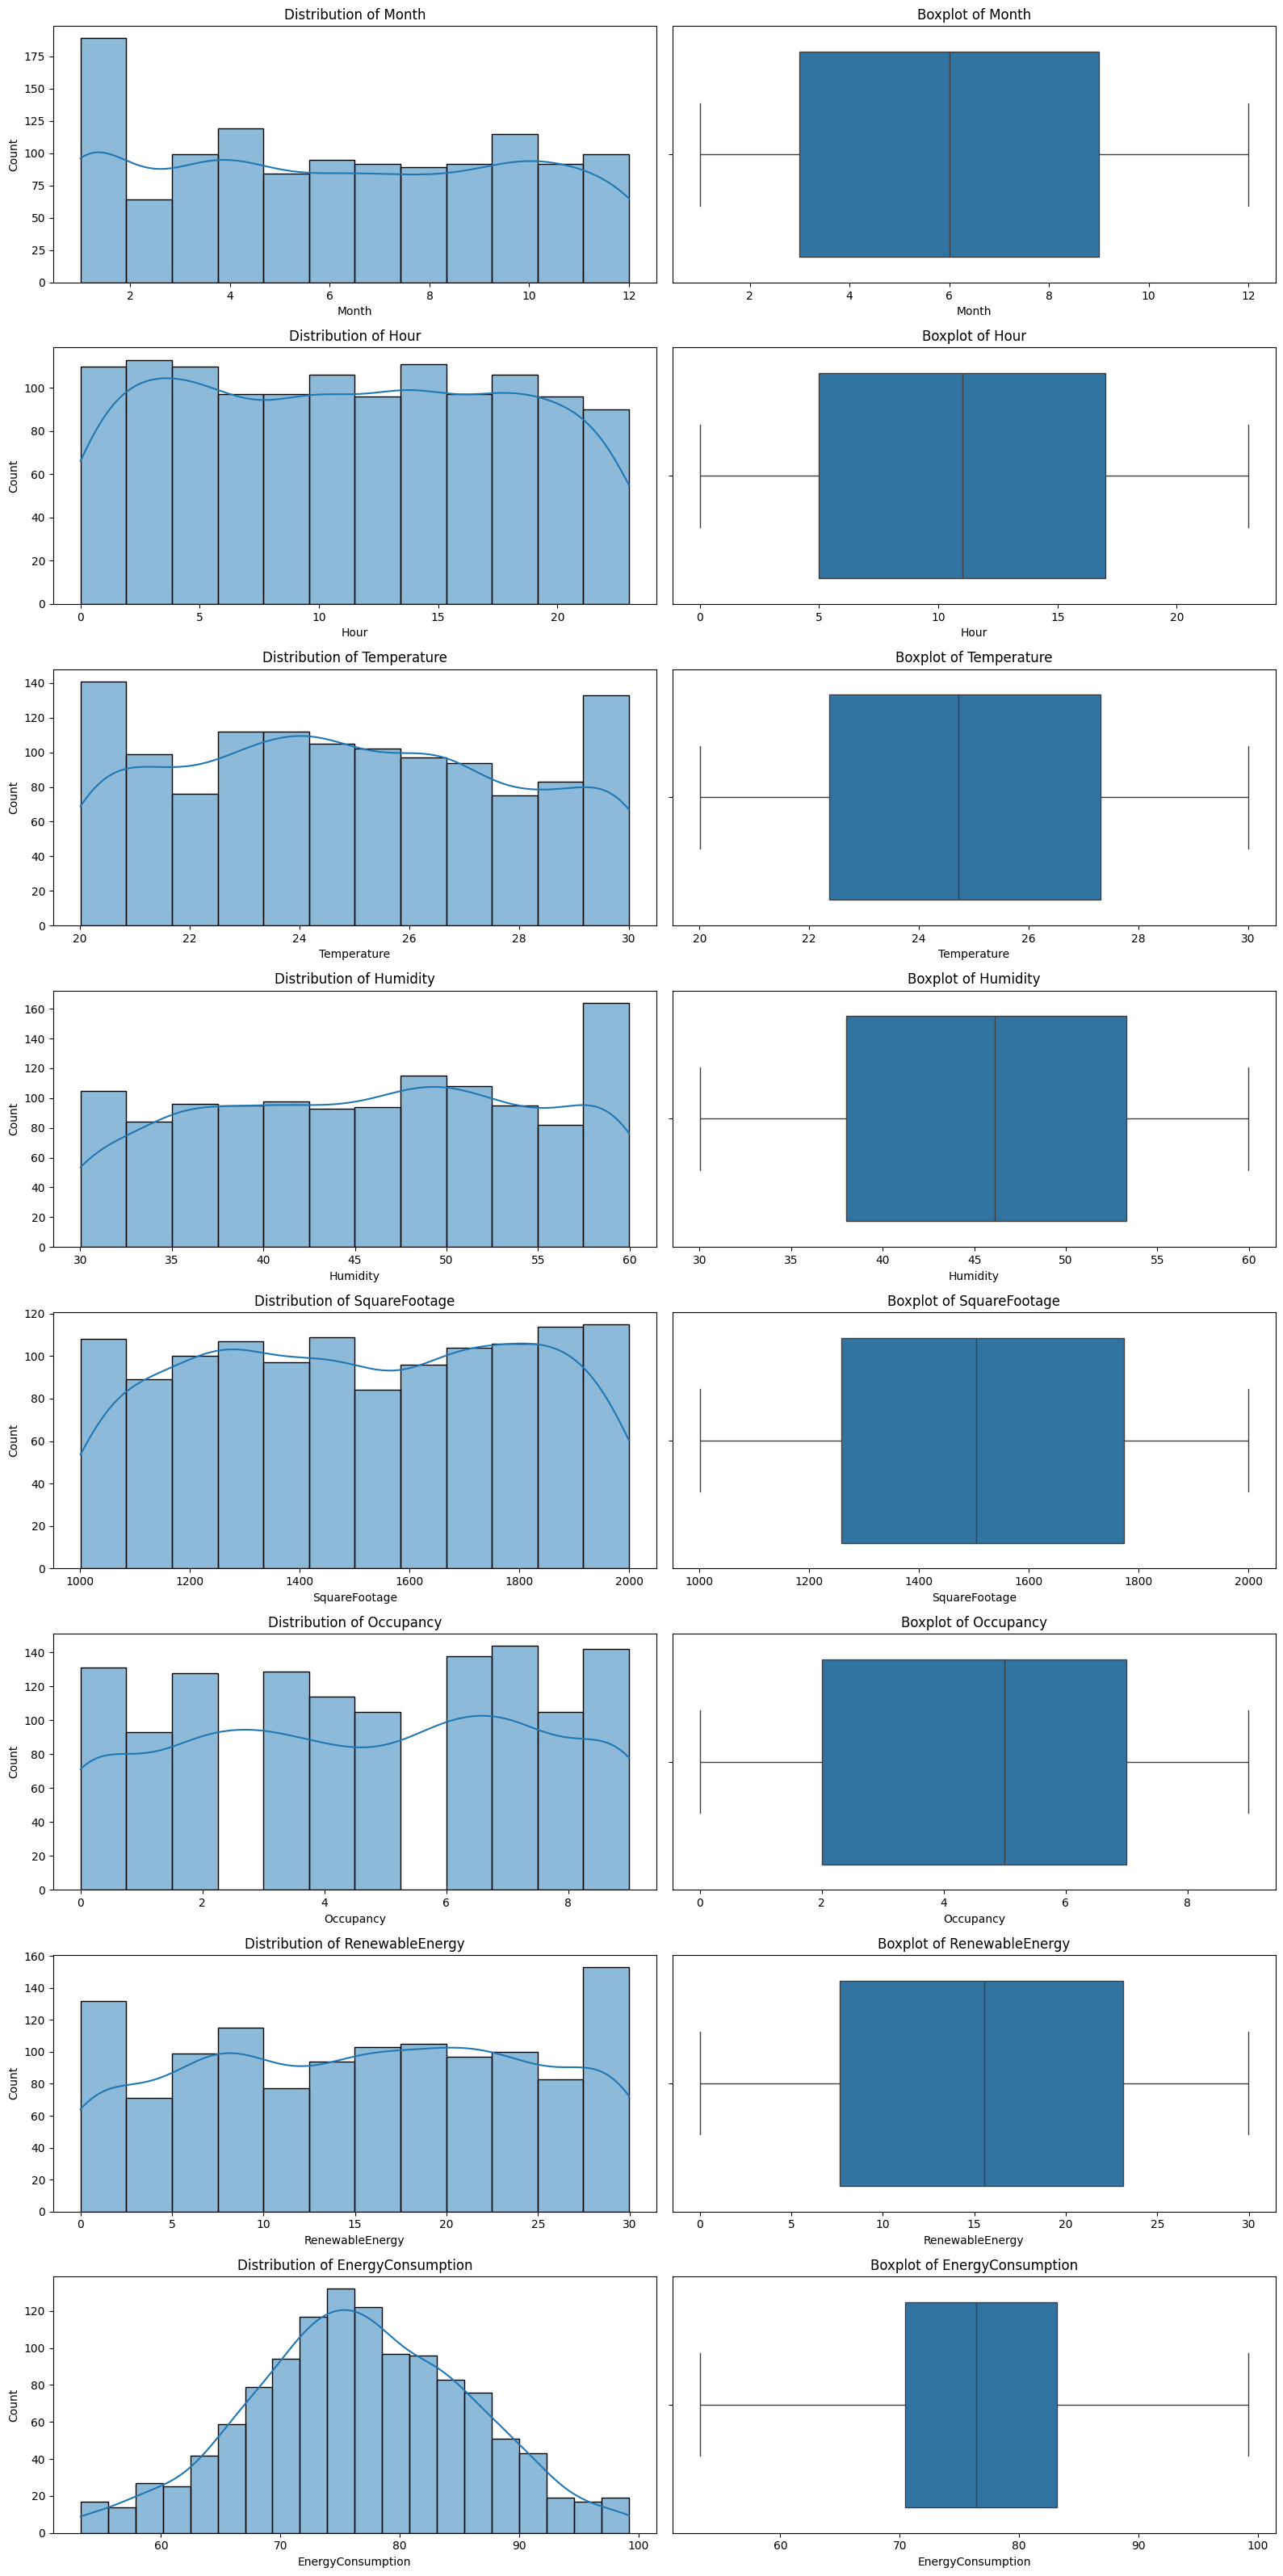

In [ ]:
plt.figure(figsize=(16, 4 * len(num)))

for i, col in enumerate(num):
    plt.subplot(len(num), 2, 2*i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(len(num), 2, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

From the histogram and boxplots above,
- **No outliers are present**, there is no dots or cross symbols in the boxplot for every variable. Yay!
- **Month**: Slightly right-skewed due to the peak in January, but no abnormalities.
- **Hour**: Nicely distributed with the even bars.
- **Temperature**: Few peaks on the left & right side (lowest and highest temperature), but still normal.
- **Humidity**: Slight peak on the right (skewed a little), but still normal.
- **SquareFootage**: Distribution is OK, but the value ranges from 1000-2000 sqft, which is very different compared to the other variables whose range falls below 100. Can be treated with scaling.
- **Occupancy**: Uneven histogram distribution, slightly left-skewed on the boxplot. May benefit from scaling.
- **RenewableEnergy**: Wavy histogram but the boxplot shows no abnormalities.
- **EnergyConsumption** (target variable): **normally distibuted** (bell-shaped), and this is good for model that assumes normality in the prediction such as linear regression.

### Check skew in numbers
We cannot rely solely in our eyes to see the skewness, so asking help from statistics may come in handy this time to confirm our current assumptions on the data distribution.

In [ ]:
# Check skewness
num_col = df[num]
num_col.skew()

,0
Month,0.045244
Hour,0.030769
Temperature,0.079179
Humidity,-0.073103
SquareFootage,-0.032496
Occupancy,-0.058345
RenewableEnergy,-0.047726
EnergyConsumption,-0.030749


The data skewness is very small, all of them falls at either 0.0x or -0.0x (where x is a random integer). We can safely assume that our data is not skewed and we can do scaling only to make the data falls within the same range. No wonder it's quite hard to interpret the skewness only with our eyes, because the data is not too skewed.

### Train Test Split
After the preprocessing steps are done, what's left is to split the data to train, test, and val data (70/20/10) and perform our final scaling process. First, we need to separate the X and y variables. The X variables will be the input to our model, and it will be all variables except for EnergyConsumption. EnergyConsumption will be our target or y variable.

In [ ]:
# Splitting X and y
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED_VALUE)

# Train val split
'''
Now, our train data is 80% of the whole set. We want to split them to 70% train and 10% val.
10%/80% is 12.5% -> so the test_size (or val size in this case) is 0.125, so the val data is 10% of the
full dataset, not 10% of the splitted train dataset.
'''
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=SEED_VALUE)

# Check sizes
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Val size: {len(X_val)}")

Train size: 860
Test size: 246
Val size: 123


In [ ]:
# Check the total data
total = len(X_train) + len(X_test) + len(X_val)
print("Total data: ", total)
print("Train: ", 0.7*total)
print("Test: ", 0.2*total)
print("Val: ", 0.1*total)

Total data:  1229
Train:  860.3
Test:  245.8
Val:  122.9


In [ ]:
X_train.shape[1]

20

Our data has been split into train, test, and val data and no data is lost during the splitting process because from 1229 rows, we can still maintain the total length of train, test, and val to 1229 rows as well. We have 17 train data columns, which will be our input dimension.

### Scaling
Since the data is not skewed and close to normal distribution, we will perform **StandardScaler** that will scale the data so the mean is 0 and the std is 1. Scaling is needed even though there is no skewness or outlier, because the model can benefit if the data points fall within a similar range.

For the y variable, I will use **MinMaxScaler**. I actually have tried to scale it using StandardScaler, however the result dissatisfies me -- the loss is so high at 0.9 to 1.0. When using MinMaxScaler, the **loss is way better** as attached below. And because MinMaxScaler will convert the answer to 0 to 1, I will be using **Sigmoid activation function for the output layer** (even though Sigmoid is usually used for binary classification, but since I applied MinMaxScaler where the output is 0 to 1, Sigmoid also produces the same range, so this can ensure that the model's prediction matches the scaler).

p.s.: Scaling is done after splitting the data so there won't be data leakage -- the scaler will learn from train data only, and the learning will be applied to test and val.

---

Scaling will be done for Month, Hour, Occupancy, Temperature, Humidity, SquareFootage, RenewableEnergy, and EnergyConsumption, because their values differ greatly compared to one another, so it is better to get our numerical variables within the same range.

I will make 2 separate scalers for X and y variables. Why? Because I want to use the scaler_y to inverse transform my y variable later, and I will need a separated, isolated scaler for y_variable. And I will keep a copy of the unscaled y test because it will be used to measure the model's performance, compared to the actual values.

In [ ]:
y_unscaled = y_test.copy()
y_unscaled

,EnergyConsumption
382,91.233133
770,83.932539
834,62.902567
814,75.369438
97,69.758303
...,...
43,63.298668
300,70.689785
897,86.669094
974,67.069184


In [ ]:
# Scaler
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

# Select columns to scale for X
columns_to_scale_X = ['Month', 'Hour', 'Occupancy', 'Temperature', 'Humidity', 'SquareFootage', 'RenewableEnergy']

# Scale X
X_train[columns_to_scale_X] = scaler_X.fit_transform(X_train[columns_to_scale_X])
X_test[columns_to_scale_X] = scaler_X.transform(X_test[columns_to_scale_X])
X_val[columns_to_scale_X] = scaler_X.transform(X_val[columns_to_scale_X])

# Scale y
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

# Check data
X_train.head()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_No,Holiday_Yes,HVACUsage_Off,HVACUsage_On,LightingUsage_Off,LightingUsage_On
286,-0.592795,0.075441,1.642867,-1.223356,1.064313,0.867405,-0.292765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
815,-0.869411,-1.088307,-1.207309,0.814460,0.599162,0.516856,0.832408,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
490,0.513670,0.075441,0.354930,0.207992,1.469294,-0.885340,-0.874065,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1002,1.066902,-0.942838,1.642867,-1.176822,-0.910352,0.166307,0.135130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
421,-0.316179,-0.506433,-1.061488,-1.401659,1.290935,0.867405,0.221016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
X_test.head()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_No,Holiday_Yes,HVACUsage_Off,HVACUsage_On,LightingUsage_Off,LightingUsage_On
382,0.237054,-1.233775,0.333384,-0.202801,1.239572,0.166307,-1.694920,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
770,0.237054,-1.379243,0.646722,1.543756,-1.560509,-0.184242,1.578757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
834,-1.422643,-0.942838,-1.530503,-0.072163,0.679227,1.217954,1.281030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
814,-1.422643,0.802783,-1.312613,-1.117415,0.108551,1.217954,-1.526645,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
97,-0.039563,0.220909,-0.198703,0.598611,0.823436,1.568503,0.424817,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Now that the data has fallen on similar range, let's make the models!

## b. Baseline Model
There will be 2 baseline models: 1 sequential and 1 functional. All hidden layers will be using ReLU, as requested from the question. For starters, I will make the model as follows:

**Sequential model**\
3 hidden layers, min. number of neurons: 2x20 = 40 (256 -> 128 -> 64)

**Functional model**\
4 hidden layers, min. number of neurons: 2x20 = 40 (80 -> 68 -> 50 -> 40)

---

Before making the models, we need to make the **tensor data first** so it can be processed using tensorflow. The data will be split into **8 batches**, which means that for every epoch, the model will process 8 rows of the data and update the weights. Why 8 batches? Because the data that we have is very limited (only ~1200 rows), so training our model will a large batch may result to the model not learning enough! 😬

To reduce the risk of overfitting, I will use **dropout layers** (10%). The value 10% is chosen because again, the data is very limited, so dropping out too many layers may result poorly.

In [ ]:
# Creating the tensor dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(8)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(8)

### Sequential model
Three hidden layers will be used, each hidden layer satisfies the requirements to use relu as the activation function and the minimum number of neurons is > twice the input size. The output layer will use no activation function (linear), especially since we have performed Standard Scaler, so we want to maintain the result as is, and do inverse transform later to get the actual value.

In [ ]:
# Sequential model
model_seq = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)), # input layer with the size of X_train columns
    Dense(256, activation="relu"), # hidden layer 1
    Dense(128, activation="relu"), # hidden layer 2
    Dense(64, activation="relu"), # hidden layer 3
    Dense(1, activation="sigmoid") # output layer
])
model_seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,593 (182.00 KB)

 Non-trainable params: 0 (0.00 B)

### Functional model
Four hidden layers will be used, each hidden layer satisfies the requirements to use relu as the activation function and the minimum number of neurons is > twice the input size. The output layer will use no activation function (linear), especially since we have performed Standard Scaler, so we want to maintain the result as is, and do inverse transform later to get the actual value.

In [ ]:
# Functional model
inputs = Input(shape=(X_train.shape[1], )) # input layer
x = Dense(80, activation='relu')(inputs) # hidden layer 1
x = Dense(68, activation='relu')(x) # hidden layer 2
x = Dense(50, activation='relu')(x) # hidden layer 3
x = Dense(40, activation='relu')(x) # hidden layer 4
outputs = Dense(1, activation='sigmoid')(x) # output layer

model_func = Model(inputs, outputs)
model_func.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 80)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 68)             │         5,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 40)             │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,719 (49.68 KB)

 Trainable params: 12,719 (49.68 KB)

 Non-trainable params: 0 (0.00 B)

### Model training
Let's train the model and see the performance of both, comparing the number of layers and neurons as well! The metrics used will be Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), the standard performance metrics for Linear Regression.

In [ ]:
# Sequential model
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history_seq = model_seq.fit(train_ds, validation_data=val_ds, epochs = 30)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0401 - mean_absolute_error: 0.1597 - root_mean_squared_error: 0.2001 - val_loss: 0.0400 - val_mean_absolute_error: 0.1563 - val_root_mean_squared_error: 0.2001
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0380 - mean_absolute_error: 0.1555 - root_mean_squared_error: 0.1948 - val_loss: 0.0383 - val_mean_absolute_error: 0.1530 - val_root_mean_squared_error: 0.1958
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0364 - mean_absolute_error: 0.1526 - root_mean_squared_error: 0.1908 - val_loss: 0.0370 - val_mean_absolute_error: 0.1504 - val_root_mean_squared_error: 0.1925
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0352 - mean_absolute_error: 0.1502 - root_mean_squared_error: 0.1875 - val_loss: 0.0360 - val_mean_absolute_error: 0.1486 - val_root_mean_squared_error: 0.1897
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0341 - mean_absolute_error: 0.1481 - root_mean_sq

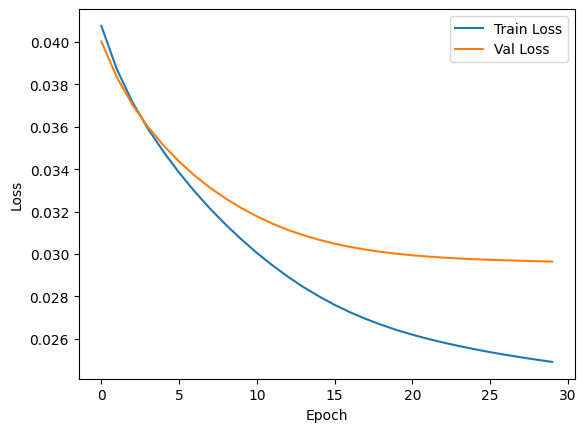

In [ ]:
# Plot the loss
train_loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss plot indicates that both the train and val loss are gradually decreasing over epoch, which suggests that the model is learning. The lines converge soon and becomes parallel afterwards. This is due to the val loss that does not continue to improve, and this may suggest overfitting by a bit since the difference between val and train loss is not much.

In [ ]:
# Functional model
model_func.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history_func = model_func.fit(train_ds, validation_data=val_ds, epochs = 30)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0428 - mean_absolute_error: 0.1645 - root_mean_squared_error: 0.2069 - val_loss: 0.0426 - val_mean_absolute_error: 0.1610 - val_root_mean_squared_error: 0.2064
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - mean_absolute_error: 0.1620 - root_mean_squared_error: 0.2037 - val_loss: 0.0414 - val_mean_absolute_error: 0.1585 - val_root_mean_squared_error: 0.2035
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0405 - mean_absolute_error: 0.1600 - root_mean_squared_error: 0.2011 - val_loss: 0.0404 - val_mean_absolute_error: 0.1565 - val_root_mean_squared_error: 0.2010
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396 - mean_absolute_error: 0.1582 - root_mean_squared_error: 0.1989 - val_loss: 0.0396 - val_mean_absolute_error: 0.1549 - val_root_mean_squared_error: 0.1989
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - mean_absolute_error: 0.1567 - root_mean_squ

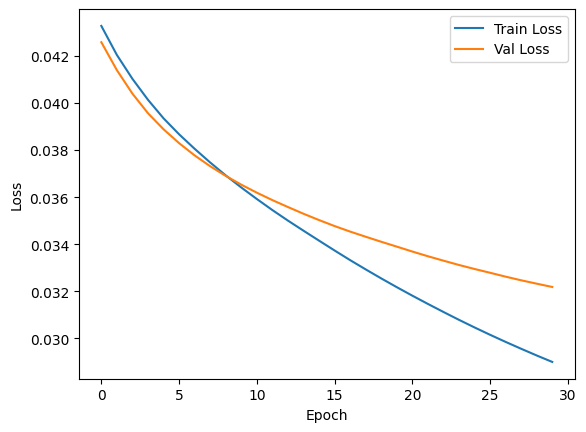

In [ ]:
# Plot the loss
train_loss = history_func.history['loss']
val_loss = history_func.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss plot indicates that both the train and val loss are gradually decreasing over epoch, which suggests that the model is learning. However, the val loss seems to plateau at around 0.036, while the train loss continues to decline. This may suggest a hint of overfitting, where the model continues to improve for train data but stop improving for val data. However, the train and val loss difference is very small at around 0.002, indicating that the overfitting is minimal and should not be a big concern.

## c. Model Modification
Here, I will perform some modification to the model.\
**Sequential model**
- **Finetune number of neurons (min. 40), LR (1e-4 to 1e-6), dropout (0.1 to 0.3) and epochs (max 30)** to see what parameters suit the model the best.

**Functional model**
- Try **LeakyReLU** as the activation function instead of ReLU because I have used StandardScaler for X variable -> negative values present. Instead of getting rid of all negative values, LeakyReLU will make the value very small but not zero. This will minimize the risk of dying neurons.
- Use the **more number of neurons** (256, 128, 64) for comparison of bigger vs smaller neurons in limited data.
- Apply **EarlyStopping** (patience=3) to stop the training when the loss does not improve after 3 consecutive epochs and **ReduceLROnPlateau** to adjust the learning rate whenever the loss is plateauing (or stable, not improving).

### Sequential model fine tuning

In [ ]:
# Hyperparameter tuning
def model_builder(hp):
  # Tune the number of neurons
  hp_units = hp.Int('units', min_value = 40, max_value = 64, step = 4)

  # Same sequential model as above
  model = tf.keras.Sequential([
      Input(shape=(X_train.shape[1], )),
      Dense(hp_units*4, activation='relu'),
      Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)),
      Dense(hp_units*2, activation='relu'),
      Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)),
      Dense(hp_units, activation='relu'),
      Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)),
      Dense(1, activation='sigmoid')
  ])

  # Tune learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss',
                     max_epochs = 30,
                     factor = 3,
                     directory = "exp",
                     project_name = "kt")

Reloading Tuner from exp/kt/tuner0.json


In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
tuner.search(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), callbacks = [early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps.values

{'units': 56,
 'dropout_rate': 0.25,
 'learning_rate': 0.0001,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

The fine-tuning result is to use 56 neurons (satisfies the requirement of min. 2xinput dim), so I will use 56, 112, and 224 neurons. I will add dropout layers (0.25) to drop 25% of the layers so it will be less prone to the risk of overfitting. The learning rate will be increased from 1e-6 to 1e-4, and the number of epoch is 30.

In [ ]:
# Sequential model tuned
model_seq_tuned = tf.keras.Sequential([
      Input(shape=(X_train.shape[1], )),
      Dense(56*4, activation='relu'),
      Dropout(0.25),
      Dense(56*2, activation='relu'),
      Dropout(0.25),
      Dense(56, activation='relu'),
      Dropout(0.25),
      Dense(1, activation='sigmoid')
  ])

In [ ]:
model_seq_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history_seq_tuned = model_seq_tuned.fit(train_ds, validation_data=val_ds, epochs = 30, callbacks = [early_stopping])

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0457 - mean_absolute_error: 0.1708 - root_mean_squared_error: 0.2137 - val_loss: 0.0364 - val_mean_absolute_error: 0.1531 - val_root_mean_squared_error: 0.1907
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377 - mean_absolute_error: 0.1557 - root_mean_squared_error: 0.1940 - val_loss: 0.0328 - val_mean_absolute_error: 0.1454 - val_root_mean_squared_error: 0.1812
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348 - mean_absolute_error: 0.1499 - root_mean_squared_error: 0.1864 - val_loss: 0.0305 - val_mean_absolute_error: 0.1403 - val_root_mean_squared_error: 0.1748
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 - mean_absolute_error: 0.1438 - root_mean_squared_error: 0.1813 - val_loss: 0.0292 - val_mean_absolute_error: 0.1377 - val_root_mean_squared_error: 0.1708
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - mean_absolute_error: 0.1410 - root_mean_squ

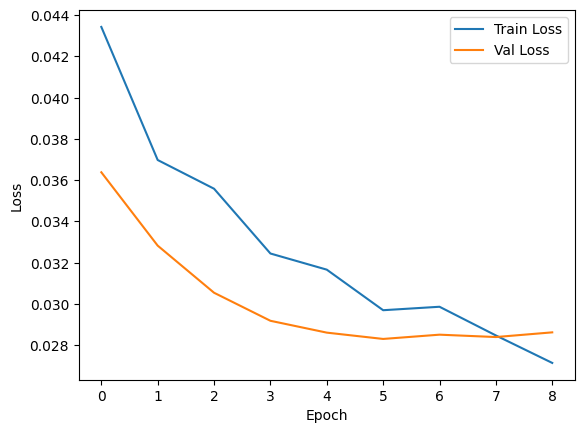

In [ ]:
# Plot the loss
train_loss = history_seq_tuned.history['loss']
val_loss = history_seq_tuned.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

On this plot, it is seen that both the val and train loss are decreasing over time, which suggests that the model is learning well. We can see that on the 7th epoch, the two lines converge, and the iteration stops early on the 8th epoch because the loss does not improve after 3 consecutive epochs. Compared to the baseline model, the loss is about the same (drops to around 0.028, with the baseline model has slightly lower loss). The baseline model shows slight overfitting, while this model has minimal overfitting, because the epoch stops early, thanks to the callback function! The gap between val and train loss is smaller too in this plot compared to the baseline model.

### Functional model modification

In [ ]:
# # Clear session when re-running cells so the model won't remember the previous learning
# K.clear_session()
# gc.collect()

4473

In [ ]:
# Functional model modification
inputs = Input(shape=(X_train.shape[1], )) # input layer
x = Dense(256)(inputs)
x = LeakyReLU()(x) # hidden layer 1
x = Dense(128)(x)
x = LeakyReLU()(x) # hidden layer 2
x = Dense(64)(x)
x = LeakyReLU()(x) # hidden layer 3
# x = Dense(64)(x)
# x = LeakyReLU()(x) # hidden layer 4
outputs = Dense(1)(x) # output layer

model_func_tuned = Model(inputs, outputs)
model_func_tuned.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,593 (182.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_func_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Initialize ReduceLROnPlateau to adjust learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
history_func_tuned = model_func_tuned.fit(train_ds, validation_data=val_ds, epochs = 50, callbacks = [early_stopping, reduce_lr])

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3460 - mean_absolute_error: 0.5301 - root_mean_squared_error: 0.5880 - val_loss: 0.3328 - val_mean_absolute_error: 0.5210 - val_root_mean_squared_error: 0.5769 - learning_rate: 1.0000e-06
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3242 - mean_absolute_error: 0.5101 - root_mean_squared_error: 0.5692 - val_loss: 0.3121 - val_mean_absolute_error: 0.5012 - val_root_mean_squared_error: 0.5587 - learning_rate: 1.0000e-06
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3036 - mean_absolute_error: 0.4909 - root_mean_squared_error: 0.5509 - val_loss: 0.2926 - val_mean_absolute_error: 0.4821 - val_root_mean_squared_error: 0.5409 - learning_rate: 1.0000e-06
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2843 - mean_absolute_error: 0.4722 - root_mean_squared_error: 0.5330 - val_loss: 0.2743 - val_mean_absolute_error: 0.4637 - val_root_mean_squared_error: 0.5237 - learning_rate: 1.0000e-06


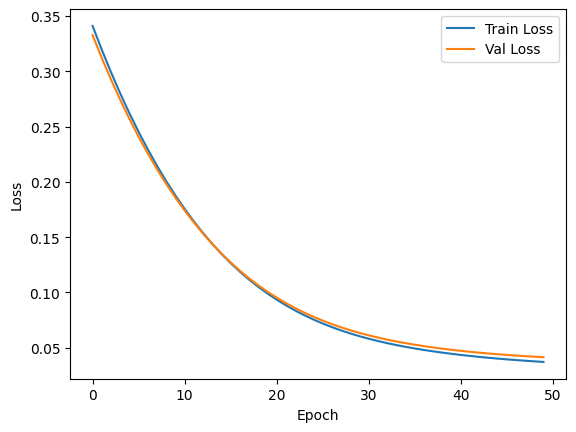

In [ ]:
# Plot the loss
train_loss = history_func_tuned.history['loss']
val_loss = history_func_tuned.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss plot here looks like both the train and val loss fits perfectly -- converging from the beginning until the end, with the loss gradually decreasing. This beautiful plot happens because I removed the sigmoid activation function from the output layer. However, the final result may not be satisfying because using sigmoid in the output layer is actually recommended if we are using minmax scaler, to keep the result within 0 to 1. Without sigmoid, the result may be outside the range.

## d. Evaluation

### Prediction
I will compile all the prediction from each model first to predict the value of test_ds.

In [ ]:
# Predict using sequential model
seq_y_pred = model_seq.predict(test_ds)
seq_y_pred = scaler_y.inverse_transform(seq_y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Predict using functional model
func_y_pred = model_func.predict(test_ds)
func_y_pred = scaler_y.inverse_transform(func_y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Predict using sequential model tuned
seq_tuned_y_pred = model_seq_tuned.predict(test_ds)
seq_tuned_y_pred = scaler_y.inverse_transform(seq_tuned_y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Predict using functional model tuned
func_tuned_y_pred = model_func_tuned.predict(test_ds)
func_tuned_y_pred = scaler_y.inverse_transform(func_tuned_y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Plotting
As the y_unscaled is DataFrame and I want to create a scatterplot with seaborn that only accepts 1D data, I will flatten the values first.

In [ ]:
y_true = y_unscaled.values.flatten()

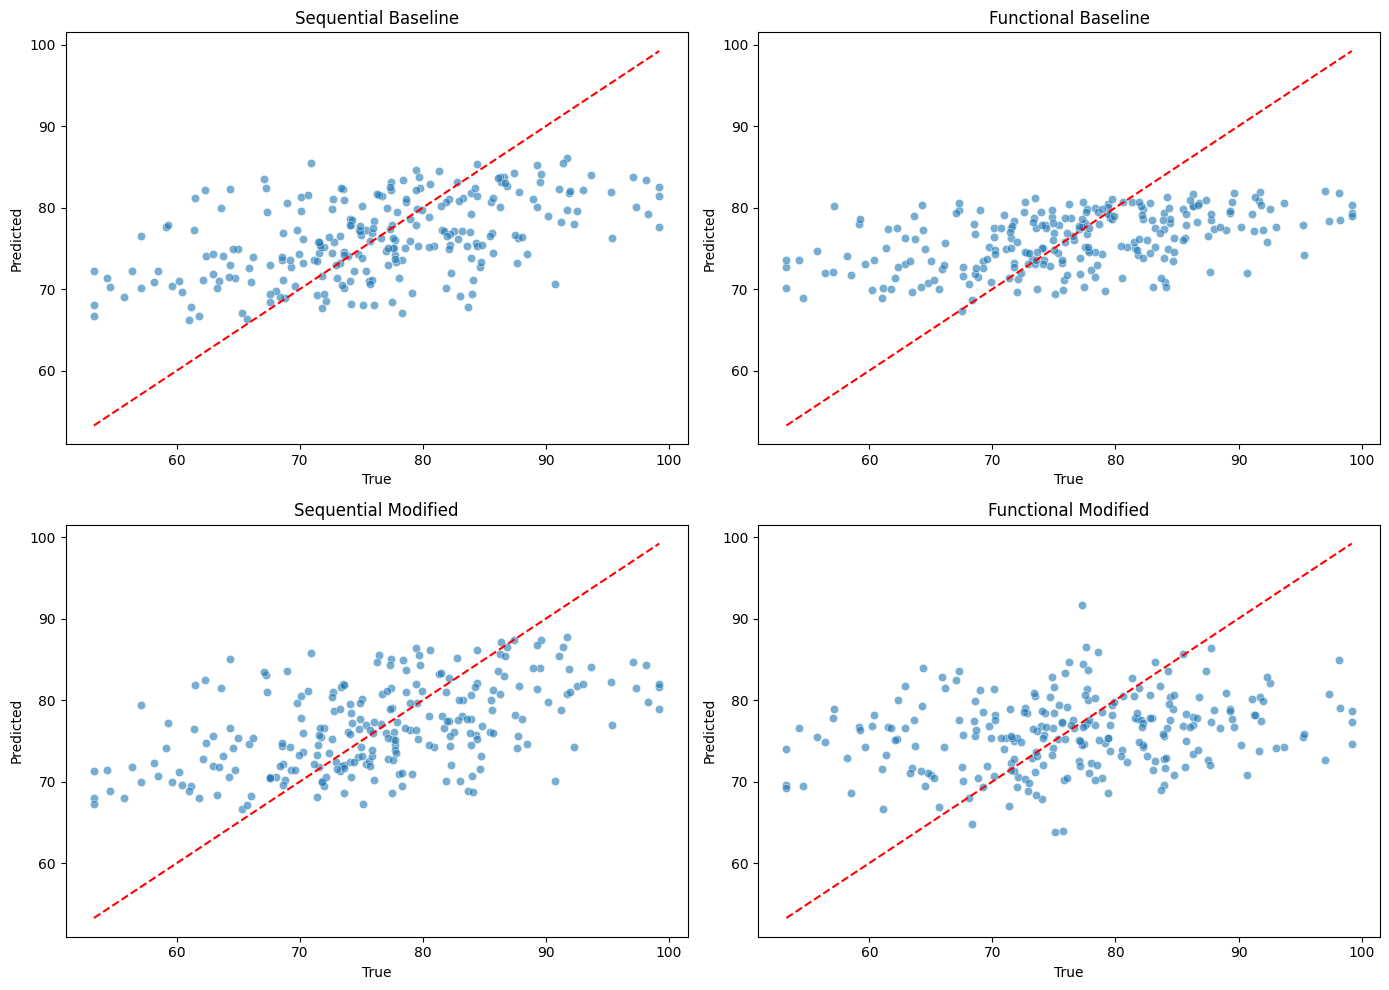

In [ ]:
# Plotting the regression for better visualization
preds = [seq_y_pred, func_y_pred, seq_tuned_y_pred, func_tuned_y_pred]
titles = ['Sequential Baseline', 'Functional Baseline', 'Sequential Modified', 'Functional Modified']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.scatterplot(x=y_true, y=preds[i].flatten(), ax=ax, alpha=0.6)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x line
    ax.set_title(titles[i])
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

### Performance metrics
As stated above, I will use:
- Mean Absolute Error (MAE): Measures the average magnitude of the errors in a set of predictions. Lower MAE suggests that the model's predictions are closer to the true value.
- Root Mean Squared Error (RMSE): Square root of the average of squared differences between the true and predicted value. Penalizes large errors more than MAE. Lower RMSE indicates better model performance.
- R-square score: Indicates how well the model captures the variance in the target variable. R2 closer to 1 means better fit, the model explains more variability.

In [ ]:
results = {
    "Model": [],
    "MAE": [],
    "RMSE": [],
    "R2": []
}

for name, pred in zip(titles, preds):
    results["Model"].append(name)
    results["MAE"].append(mean_absolute_error(y_true, pred))
    results["RMSE"].append(root_mean_squared_error(y_true, pred))
    results["R2"].append(r2_score(y_true, pred))

results = pd.DataFrame(results)
results

,Model,MAE,RMSE,R2
0,Sequential Baseline,6.810809,8.551440,0.257728
1,Functional Baseline,6.959081,8.835663,0.207566
2,Sequential Modified,6.800730,8.553517,0.257367
3,Functional Modified,7.873316,9.858700,0.013439


### Inference
- The models, ranked by their performance from the highest to lowest: Sequential Baseline -> Sequential Modified -> Functional Baseline -> Functional Modified.
- Both **sequential models outperform the functional models** and they perform similarly. The parameters tuned for sequential model results in similar number of neurons, higher dropout level, and higher learning rate. In the end, they perform similarly.
- The **R2 scores for sequential models and functional baseline are around 20-25%**, indicating that they can explain around 20% of the data variance.
- **Functional modified performs worse**, suspected due to the usage of too many neurons and removing the sigmoid function from the output layer, so the prediction may not be in range. Remember that we used MinMaxScaler for the y-variable scaling, so using Sigmoid is recommended, but I wanted to try removing the Sigmoid to see the difference. It performs well on the loss plot but poor on the metrics. The very low R2 suggests that the model may be too complex and fail to explain the variance.
- **None of the model fits the regression line perfectly**. More adjustments and tuning are needed -- but one of the concerns is the limited amount of data, only around 1200, it is not enough to build a staple ANN model.

---

### Key Takeaways
- When working with small data, avoid overcomplicating the model. Try using less neurons and layers.
- Try to match the scaling method with the activation function, such as MinMaxScaler that works well with Sigmoid.

## e. Video Explanation
Accessible [here](https://drive.google.com/file/d/1pHm3FKKOcD4eauC8WoVlC7H8Bo1_liZN/view?usp=drive_link)